# ContinuousDP: Stochastic Optimal Growth Model

In [1]:
using QuantEcon
using BasisMatrices
using ContinuousDPs
using Random
using PythonPlot
const plt = PythonPlot.pyplot;

In [2]:
alpha = 0.4
beta = 0.96
mu = 0
sigma = 0.1;

In [3]:
f(s, x) = log(x)
g(s, x, e) = (s - x)^alpha * e;

In [4]:
shock_size = 250
shocks = exp.(mu .+ sigma * randn(shock_size))
weights = fill(1/shock_size, shock_size);

In [5]:
grid_max = 4.
n = 30
s_min, s_max = 1e-5, grid_max
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (1.0e-5,) × (4.0,).
Basis families are Cheb


In [6]:
x_lb(s) = s_min
x_ub(s) = s;

In [7]:
ab = alpha * beta
c1 = log(1 - ab) / (1 - beta)
c2 = (mu + alpha * log(ab)) / (1 - alpha)
c3 = 1 / (1 - beta)
c4 = 1 / (1 - ab)

# True optimal policy
c_star(y) = (1 - alpha * beta) * y

# True value function
v_star(y) = c1 + c2 * (c3 - c4) + c4 * log(y);

In [8]:
cdp = ContinuousDP(f, g, beta, shocks, weights, x_lb, x_ub, basis);

In [9]:
@code_warntype ContinuousDP(f, g, beta, shocks, weights, x_lb, x_ub, basis)

MethodInstance for ContinuousDP(::typeof(f), ::typeof(g), ::Float64, ::Vector{Float64}, ::Vector{Float64}, ::typeof(x_lb), ::typeof(x_ub), ::Basis{1, Tuple{ChebParams{Float64}}})
  from ContinuousDP(f::Function, g::Function, discount::Float64, shocks::Array{Float64}, weights::Vector{Float64}, x_lb::Function, x_ub::Function, basis::Basis) @ ContinuousDPs ~/Development/ContinuousDPs.jl/src/cdp.jl:118
Arguments
  #self#::Type{ContinuousDP}
  f::Core.Const(Main.f)
  g::Core.Const(Main.g)
  discount::Float64
  shocks::Vector{Float64}
  weights::Vector{Float64}
  x_lb::Core.Const(Main.x_lb)
  x_ub::Core.Const(Main.x_ub)
  basis::Basis{1, Tuple{ChebParams{Float64}}}
Locals
  cdp::ContinuousDP{1, Vector{Float64}, Vector{Float64}, typeof(f), typeof(g), typeof(x_lb), typeof(x_ub)}
  interp::ContinuousDPs.Interp{1, Vector{Float64}, Matrix{Float64}, LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}}
Body::ContinuousDP{1, Vector{Float64}, Vector{Float64}, typeof(f), typeof(g), typeof(x_lb),

## First test

In [10]:
C_star = cdp.interp.Phi \ v_star.(cdp.interp.S)
Tv = Array{Float64}(undef, cdp.interp.length)
C = copy(C_star)
bellman_operator!(cdp, C, Tv);

In [11]:
@code_warntype bellman_operator!(cdp, C, Tv)

MethodInstance for bellman_operator!(::ContinuousDP{1, Vector{Float64}, Vector{Float64}, typeof(f), typeof(g), typeof(x_lb), typeof(x_ub)}, ::Vector{Float64}, ::Vector{Float64})
  from bellman_operator!(cdp::ContinuousDP, C::Vector{Float64}, Tv::Vector{Float64}) @ ContinuousDPs ~/Development/ContinuousDPs.jl/src/cdp.jl:379
Arguments
  #self#::Core.Const(QuantEcon.bellman_operator!)
  cdp::ContinuousDP{1, Vector{Float64}, Vector{Float64}, typeof(f), typeof(g), typeof(x_lb), typeof(x_ub)}
  C::Vector{Float64}
  Tv@_4::Vector{Float64}
Locals
  Tv@_5::Vector{Float64}
Body::Vector{Float64}
1 ─       (Tv@_5 = Tv@_4)
│   %2  = ContinuousDPs.s_wise_max!::Core.Const(ContinuousDPs.s_wise_max!)
│   %3  = Base.getproperty(cdp, :interp)::ContinuousDPs.Interp{1, Vector{Float64}}
│   %4  = Base.getproperty(%3, :S)::Vector{Float64}
│   %5  = Tv@_5::Vector{Float64}
│         (Tv@_5 = (%2)(cdp, %4, C, %5))
│   %7  = ContinuousDPs.ldiv!::Core.Const(LinearAlgebra.ldiv!)
│   %8  = Base.getproperty(cdp, :in

In [12]:
grid_size = 200
grid_y = collect(range(s_min, stop=s_max, length=grid_size))
V_approx = funeval(C, cdp.interp.basis, grid_y);

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


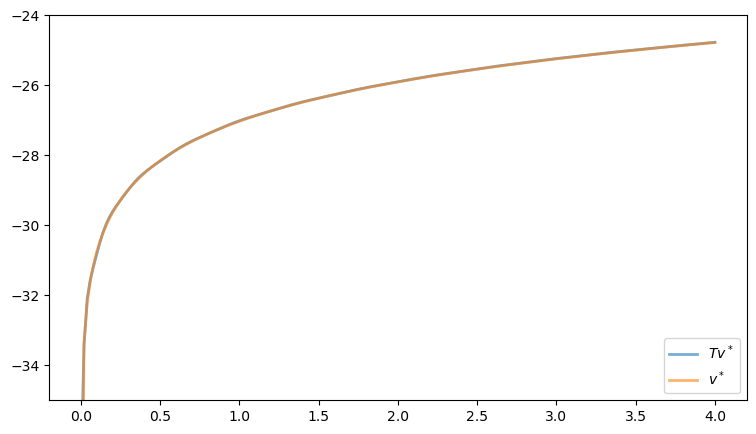

In [13]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(grid_y, V_approx, lw=2, alpha=0.6, label=L"$Tv^*$")
ax.plot(grid_y, v_star.(grid_y), lw=2, alpha=0.6, label=L"$v^*$")
ax.legend(loc="lower right")
plotshow()

In [14]:
@time bellman_operator!(cdp, C, Tv)
@time bellman_operator!(cdp, C, Tv)
@time bellman_operator!(cdp, C, Tv);

  0.019175 seconds (692.98 k allocations: 47.283 MiB, 49.70% gc time)
  0.011071 seconds (651.54 k allocations: 44.455 MiB, 20.66% gc time)
  0.011436 seconds (672.26 k allocations: 45.869 MiB, 23.10% gc time)


In [15]:
s = 2.
@code_warntype ContinuousDPs._s_wise_max(cdp, s, C)

MethodInstance for ContinuousDPs._s_wise_max(::ContinuousDP{1, Vector{Float64}, Vector{Float64}, typeof(f), typeof(g), typeof(x_lb), typeof(x_ub)}, ::Float64, ::Vector{Float64})
  from _s_wise_max(cdp::ContinuousDP, s, C) @ ContinuousDPs ~/Development/ContinuousDPs.jl/src/cdp.jl:268
Arguments
  #self#::Core.Const(ContinuousDPs._s_wise_max)
  cdp::ContinuousDP{1, Vector{Float64}, Vector{Float64}, typeof(f), typeof(g), typeof(x_lb), typeof(x_ub)}
  s::Float64
  C::Vector{Float64}
Locals
  x::Float64
  v::Float64
  res::Any
  objective::ContinuousDPs.var"#objective#3"{ContinuousDP{1, Vector{Float64}, Vector{Float64}, typeof(f), typeof(g), typeof(x_lb), typeof(x_ub)}, Float64, Vector{Float64}, Matrix{Float64}}
  sp::Matrix{Float64}
Body::Tuple{Float64, Float64}
1 ─ %1  = Core.apply_type(ContinuousDPs.Array, ContinuousDPs.Float64)::Core.Const(Array{Float64})
│   %2  = ContinuousDPs.undef::Core.Const(UndefInitializer())
│   %3  = ContinuousDPs.size::Core.Const(size)
│   %4  = Base.getpropert

In [16]:
@time ContinuousDPs._s_wise_max(cdp, s, C)
@time ContinuousDPs._s_wise_max(cdp, s, C)
@time ContinuousDPs._s_wise_max(cdp, s, C);

  0.000210 seconds (15.98 k allocations: 1.090 MiB)
  0.002117 seconds (15.98 k allocations: 1.090 MiB, 88.90% gc time)
  0.000218 seconds (15.98 k allocations: 1.090 MiB)


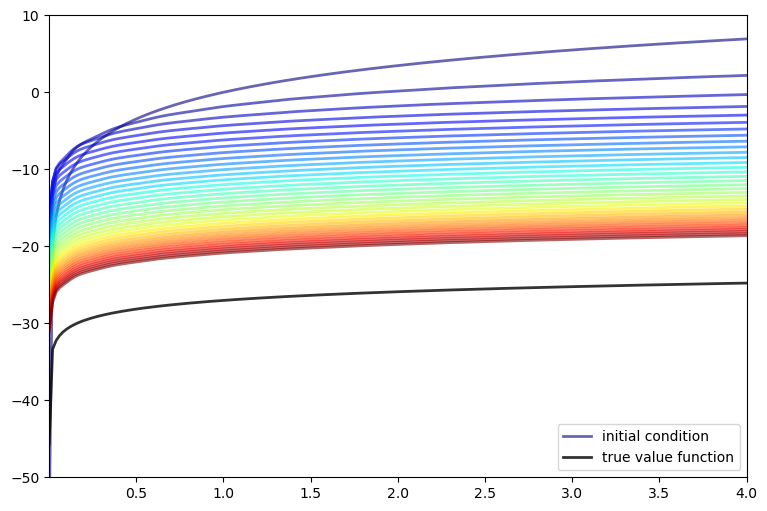

In [17]:
v_init_func(s) = 5 * log(s)
w = v_init_func.(grid_y)
n = 35

fig, ax = subplots(figsize=(9, 6))
ax.set_ylim(-50, 10)
ax.set_xlim(minimum(grid_y), maximum(grid_y))
lb = "initial condition"
jet = ColorMap("jet")
ax.plot(grid_y, w, color=jet(0), lw=2, alpha=0.6, label=lb)

S = cdp.interp.S
V = v_init_func.(S)
for i in 1:n
    C = cdp.interp.Phi \ V
    bellman_operator!(cdp, C, V)
    w = funeval(C, cdp.interp.basis, grid_y)
    ax.plot(grid_y, w, color=jet(i / n), lw=2, alpha=0.6)
end

lb = "true value function"
ax.plot(grid_y, v_star.(grid_y), "k-", lw=2, alpha=0.8, label=lb)
ax.legend.(loc="lower right")

plotshow()

## Solve by policy iteration

In [18]:
res = solve(cdp);

Compute iterate 6 with error 2.4868995751603507e-14
Converged in 6 steps


In [19]:
@code_warntype solve(cdp)

MethodInstance for solve(::ContinuousDP{1, Vector{Float64}, Vector{Float64}, typeof(f), typeof(g), typeof(x_lb), typeof(x_ub)})
  from solve(cdp::ContinuousDP{N, TR, TS}; ...) where {N, TR, TS} @ ContinuousDPs ~/Development/ContinuousDPs.jl/src/cdp.jl:581
Static Parameters
  N = 1
  TR = Vector{Float64}
  TS = Vector{Float64}
Arguments
  #self#::Core.Const(QuantEcon.solve)
  cdp::ContinuousDP{1, Vector{Float64}, Vector{Float64}, typeof(f), typeof(g), typeof(x_lb), typeof(x_ub)}
Body::ContinuousDPs.CDPSolveResult{PFI, 1, Vector{Float64}, Vector{Float64}}
1 ─ %1 = ContinuousDPs.PFI::Core.Const(PFI)
│   %2 = (#self#)(cdp, %1)::ContinuousDPs.CDPSolveResult{PFI, 1, Vector{Float64}, Vector{Float64}}
└──      return %2



In [20]:
@time res = solve(cdp)
@time res = solve(cdp)
@time res = solve(cdp);

Compute iterate 6 with error 2.4868995751603507e-14
Converged in 6 steps
  0.124732 seconds (7.42 M allocations: 498.285 MiB, 14.74% gc time)
Compute iterate 6 with error 2.4868995751603507e-14
Converged in 6 steps
  0.126477 seconds (7.42 M allocations: 498.285 MiB, 15.02% gc time)
Compute iterate 6 with error 2.4868995751603507e-14
Converged in 6 steps
  0.121432 seconds (7.42 M allocations: 498.285 MiB, 13.85% gc time)


In [21]:
set_eval_nodes!(res, grid_y);

In [22]:
@code_warntype set_eval_nodes!(res, grid_y)

MethodInstance for set_eval_nodes!(::ContinuousDPs.CDPSolveResult{PFI, 1, Vector{Float64}, Vector{Float64}}, ::Vector{Float64})
  from set_eval_nodes!(res::ContinuousDPs.CDPSolveResult{Algo, N}, s_nodes_coord::Vararg{AbstractVector, N}) where {Algo, N} @ ContinuousDPs ~/Development/ContinuousDPs.jl/src/cdp.jl:225
Static Parameters
  Algo = PFI
  N = 1
Arguments
  #self#::Core.Const(ContinuousDPs.set_eval_nodes!)
  res::ContinuousDPs.CDPSolveResult{PFI, 1, Vector{Float64}, Vector{Float64}}
  s_nodes_coord::Tuple{Vector{Float64}}
Body::ContinuousDPs.CDPSolveResult{PFI, 1, Vector{Float64}, Vector{Float64}}
1 ─ %1 = ContinuousDPs.set_eval_nodes!(res, s_nodes_coord)::ContinuousDPs.CDPSolveResult{PFI, 1, Vector{Float64}, Vector{Float64}}
└──      return %1



In [23]:
@time set_eval_nodes!(res, grid_y)
@time set_eval_nodes!(res, grid_y)
@time set_eval_nodes!(res, grid_y);

  0.070110 seconds (4.18 M allocations: 285.455 MiB, 18.87% gc time)
  0.062794 seconds (4.18 M allocations: 285.455 MiB, 15.12% gc time)
  0.064014 seconds (4.18 M allocations: 285.455 MiB, 14.91% gc time)


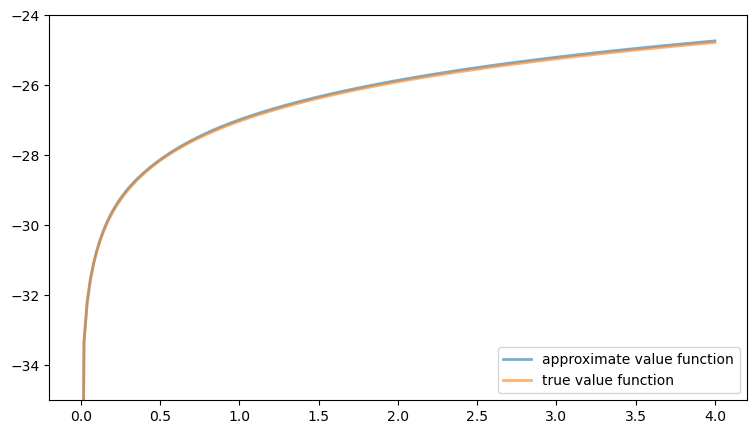

In [24]:
fig, ax = subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(grid_y, res.V, lw=2, alpha=0.6, label="approximate value function")
ax.plot(grid_y, v_star.(grid_y), lw=2, alpha=0.6, label="true value function")
ax.legend(loc="lower right")
plotshow()

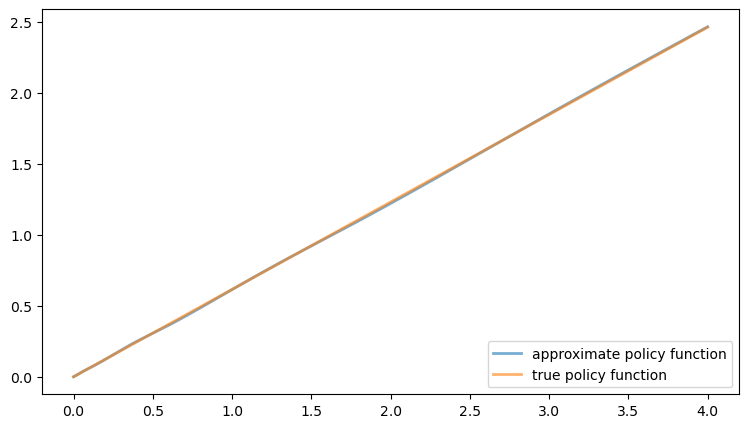

In [25]:
fig, ax = subplots(figsize=(9, 5))
ax.plot(grid_y, res.X, lw=2, alpha=0.6, label="approximate policy function")
ax.plot(grid_y, c_star.(grid_y), lw=2, alpha=0.6, label="true policy function")
ax.legend(loc="lower right")
plotshow()

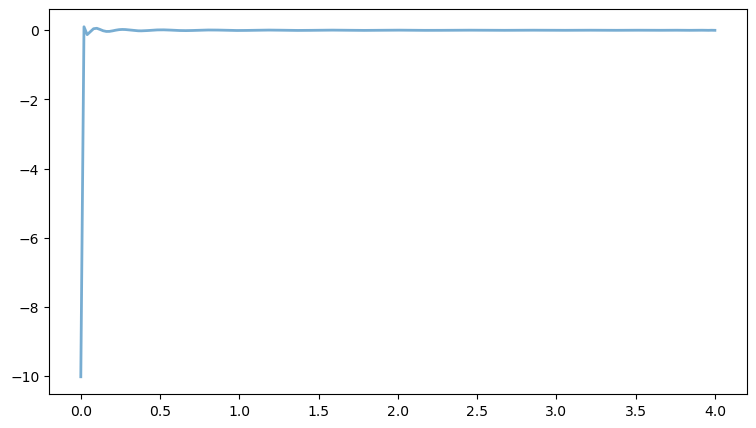

In [26]:
fig, ax = subplots(figsize=(9, 5))
ax.plot(grid_y, res.resid, lw=2, alpha=0.6, label="residual")
plotshow()

## Simulate the controlled Markov process

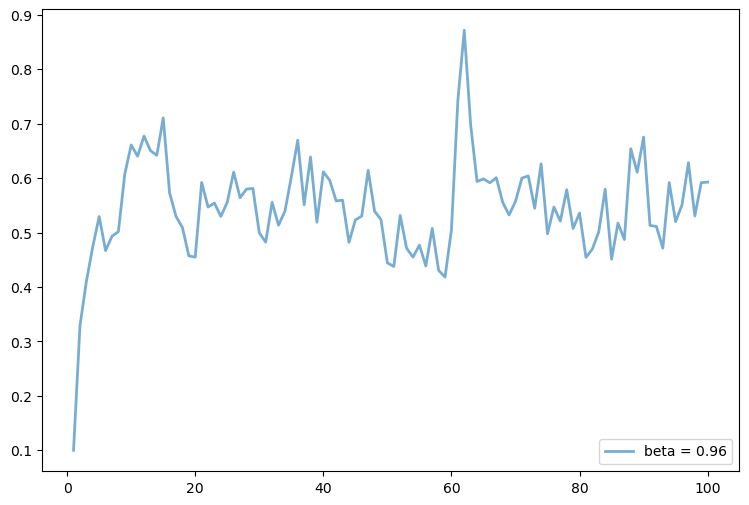

In [27]:
s_init = 0.1
ts_length = 100
y = simulate(res, s_init, ts_length)

fig, ax = subplots(figsize=(9, 6))
ax.plot(1:ts_length, y, lw=2, alpha=0.6, label="beta = $(cdp.discount)" )
ax.legend(loc="lower right")
plotshow()

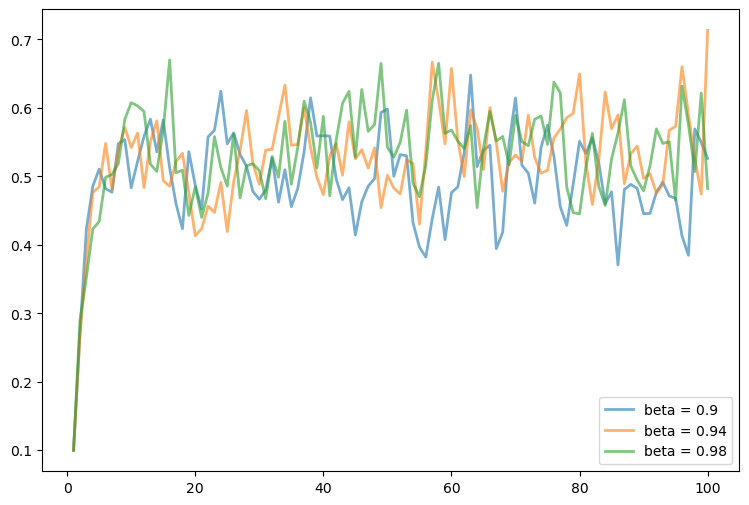

In [28]:
fig, ax = plt.subplots(figsize=(9, 6))

for beta in (0.9, 0.94, 0.98)
    cdp.discount = beta
    res = solve(cdp, verbose=0)
    set_eval_nodes!(res, grid_y)
    y = simulate(res, s_init, ts_length)
    ax.plot(1:ts_length, y, lw=2, alpha=0.6, label="beta = $(cdp.discount)" )
end

ax.legend(loc="lower right")
plotshow()

In [29]:
@code_warntype simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init)

MethodInstance for simulate!(::MersenneTwister, ::Vector{Float64}, ::ContinuousDPs.CDPSolveResult{PFI, 1, Vector{Float64}, Vector{Float64}}, ::Float64)
rng::AbstractRNG, s_path::TS, res::ContinuousDPs.CDPSolveResult{Algo, N, TR, TS}, s_init) where {Algo, N, TR, TS<:(VecOrMat)} @ ContinuousDPs ~/Development/ContinuousDPs.jl/src/cdp.jl:706
Static Parameters
  Algo = PFI
  N = 1
  TR = Vector{Float64}
  TS = Vector{Float64}
Arguments
  #self#::Core.Const(QuantEcon.simulate!)
  rng::MersenneTwister
  s_path::Vector{Float64}
  res::ContinuousDPs.CDPSolveResult{PFI, 1, Vector{Float64}, Vector{Float64}}
  s_init::Float64
Locals
  @_6::Union{Nothing, Tuple{Int64, Int64}}
  #18::ContinuousDPs.var"#18#19"
  @_8::Union{Nothing, Tuple{Int64, Int64}}
  e_ind_tail::Tuple{}
  s_ind_front::Tuple{}
  X_interp::Interpoland{Basis{1, Tuple{LinParams{Vector{Float64}}}}, Vector{Float64}, BasisMatrix{Tensor, SparseArrays.SparseMatrixCSC{Float64, Int64}}}
  basis::Basis{1, Tuple{LinParams{Vector{Float64}}}}
 

In [30]:
@time simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init)
@time simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init)
@time simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init);

  0.030516 seconds (53.20 k allocations: 2.874 MiB, 99.51% compilation time)
  0.000096 seconds (4.96 k allocations: 243.797 KiB)
  0.000101 seconds (4.96 k allocations: 243.797 KiB)
